### Imports Necessary Library

In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy import signal
import numpy as np
import pywt 
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import skew,kurtosis
from numpy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt
from keras.models import load_model
import random 

### Randomness Control

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Loading The data

In [3]:
#Load signal 
data = pd.read_csv('seizure_nonseizure_with_subject_info.csv')
data.columns

Index(['patient_id', 'EEG Fp1', 'EEG F3', 'EEG C3', 'EEG P3', 'EEG O1',
       'EEG F7', 'EEG T3', 'EEG T5', 'EEG Fc1', 'EEG Fc5', 'EEG Cp1',
       'EEG Cp5', 'EEG F9', 'EEG Fz', 'EEG Cz', 'EEG Pz', 'EEG Fp2', 'EEG F4',
       'EEG C4', 'EEG P4', 'EEG O2', 'EEG F8', 'EEG T4', 'EEG T6', 'EEG Fc2',
       'EEG Fc6', 'EEG Cp2', 'EEG Cp6', 'EEG F10', 'outcome'],
      dtype='object')

In [4]:
print(f"Shape of the original Dataset: {data.shape}")

Shape of the original Dataset: (2251510, 31)


In [5]:
data.head()

,patient_id,EEG Fp1,EEG F3,EEG C3,EEG P3,EEG O1,EEG F7,EEG T3,EEG T5,EEG Fc1,...,EEG O2,EEG F8,EEG T4,EEG T6,EEG Fc2,EEG Fc6,EEG Cp2,EEG Cp6,EEG F10,outcome
0,PN00,0.000002,-0.000010,-8.756549e-07,-0.000011,-0.000006,-0.000026,0.000002,0.000008,6.238499e-07,...,7.499440e-07,-0.000023,-0.000011,-8.377260e-06,-0.000008,0.000008,0.000005,0.000003,0.000001,0
1,PN00,-0.000003,-0.000012,2.434802e-06,-0.000013,-0.000021,-0.000031,-0.000005,-0.000005,2.488734e-06,...,9.609197e-08,-0.000025,-0.000003,8.471625e-07,0.000002,0.000007,0.000009,0.000014,-0.000003,0
2,PN00,0.000005,-0.000008,3.452706e-06,-0.000014,-0.000020,-0.000022,0.000002,-0.000004,2.183341e-06,...,-4.682577e-06,-0.000019,-0.000004,-4.296782e-07,0.000004,0.000009,0.000005,0.000006,0.000007,0
3,PN00,-0.000004,0.000008,9.512769e-06,-0.000009,-0.000017,-0.000022,0.000005,-0.000003,6.888765e-06,...,-3.759066e-06,-0.000019,-0.000003,2.744530e-06,0.000012,0.000009,0.000009,0.000008,0.000010,0
4,PN00,-0.000019,0.000002,6.717599e-06,-0.000012,-0.000021,-0.000031,-0.000005,-0.000002,8.064891e-06,...,-1.129675e-05,-0.000022,-0.000004,-4.299946e-06,0.000011,0.000008,0.000007,0.000004,0.000010,0


### Drop the `patient_id` column

In [6]:
data = data.drop(columns=["patient_id"])
print(f"After droping the patient_id the dataset shape is: {data.shape}")

After droping the patient_id the dataset shape is: (2251510, 30)


#### Data correlation


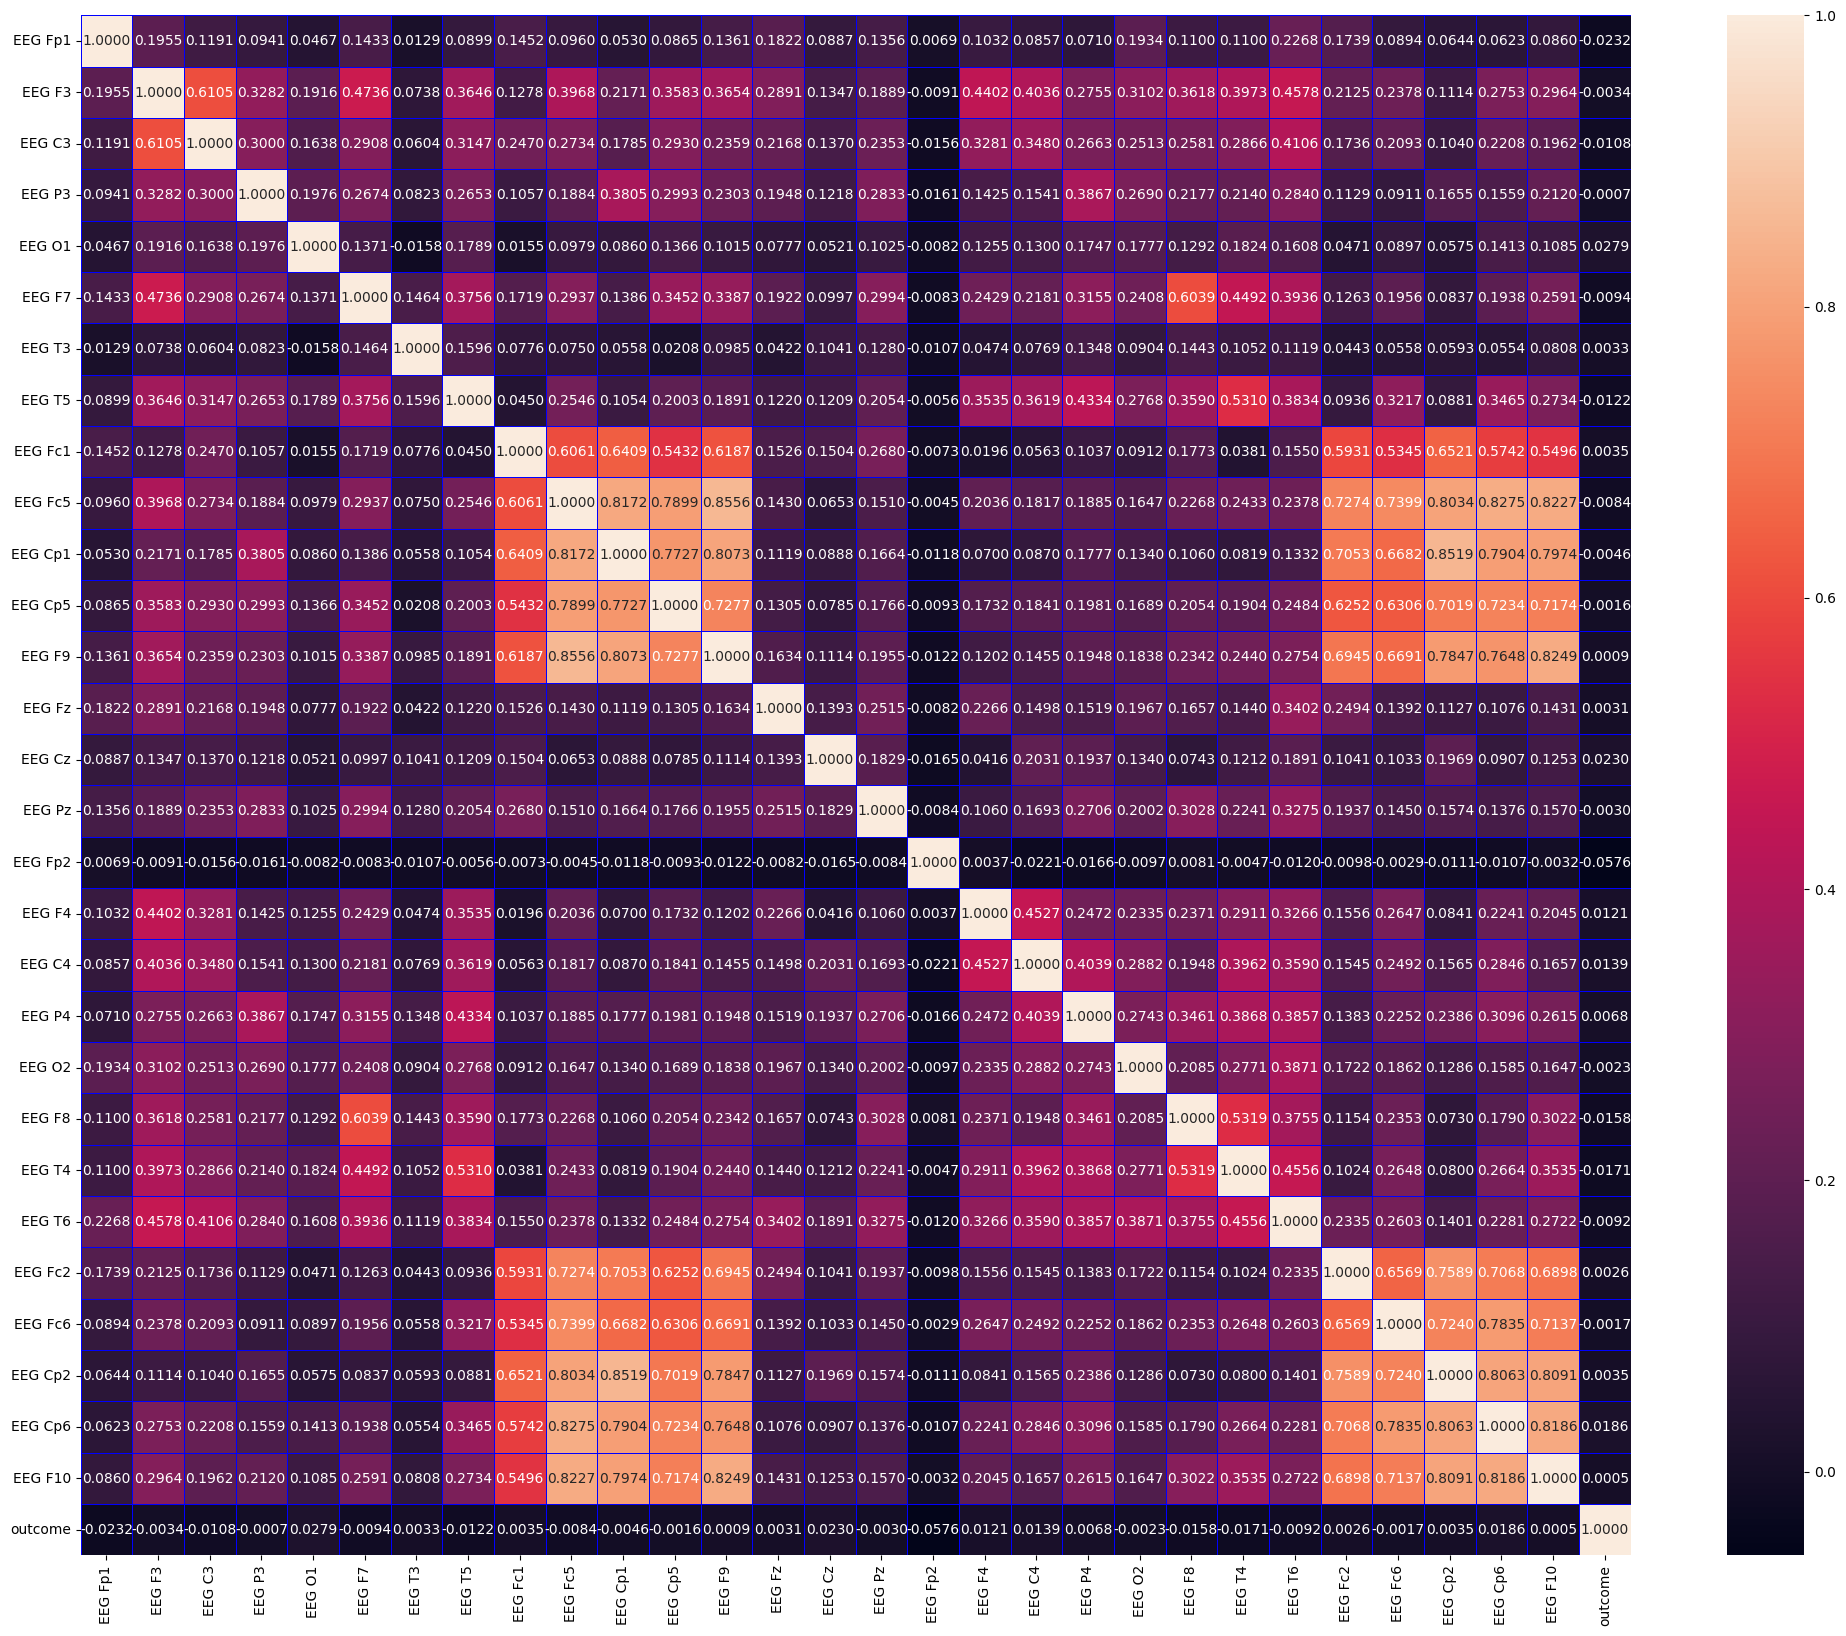

In [7]:
f, ax = plt.subplots(figsize = (25,20))
sns.heatmap(data.corr(), annot = True, linewidths = 0.5, linecolor = 'blue', fmt=".4f", ax=ax)
plt.show()

### Seizure and Non-seizure data points

In [8]:
col = data['outcome']
print(f"Total data points: {len(col)}")
print(f"total seizure data points: {col.value_counts().get(1)}")
print(f"total non-seizure data points: {col.value_counts().get(0)}")

Total data points: 2251510
total seizure data points: 1136500
total non-seizure data points: 1115010


### Standard Scalar Data Normalization

In [9]:
def normalize(eeg_data):
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(eeg_data)
    X_normalized_df = pd.DataFrame(X_normalized, columns=eeg_data.columns)
    return X_normalized_df

### Data seperation 

In [10]:
grouped_data = data.groupby('outcome')
print(len(grouped_data))

for name, group in grouped_data:
    print(f"Group '{name}' shape: {group.shape}")

preictal_data = grouped_data.get_group(0)
ictal_data = grouped_data.get_group(1)

preictal_data = preictal_data.iloc[:, :-1]
ictal_data = ictal_data.iloc[:, :-1]

print(preictal_data.columns)
print(preictal_data.shape)
print(ictal_data.shape)

print(f"non-seizure data length: {preictal_data.shape[0]/(250*60)}") 
print(f"seizure data length: {ictal_data.shape[0]/(250*60)}") 

2
Group '0' shape: (1115010, 30)
Group '1' shape: (1136500, 30)
Index(['EEG Fp1', 'EEG F3', 'EEG C3', 'EEG P3', 'EEG O1', 'EEG F7', 'EEG T3',
       'EEG T5', 'EEG Fc1', 'EEG Fc5', 'EEG Cp1', 'EEG Cp5', 'EEG F9',
       'EEG Fz', 'EEG Cz', 'EEG Pz', 'EEG Fp2', 'EEG F4', 'EEG C4', 'EEG P4',
       'EEG O2', 'EEG F8', 'EEG T4', 'EEG T6', 'EEG Fc2', 'EEG Fc6', 'EEG Cp2',
       'EEG Cp6', 'EEG F10'],
      dtype='object')
(1115010, 29)
(1136500, 29)
non-seizure data length: 74.334
seizure data length: 75.76666666666667


### Bandpass Butterworth Filter Function

In [11]:

def apply_butter_filter(signal, lowcut, highcut, fs,type):
    try:
        # Check if the signal is a NumPy array
        if isinstance(signal, np.ndarray):
            # Check if the signal is 1-dimensional
            if signal.ndim == 1:
                nyquist = 0.5 * fs
                low = lowcut / nyquist
                high = highcut / nyquist
                b, a = butter(4, [low, high], btype=type)
                filtered_signal = filtfilt(b, a, signal)
                return filtered_signal
            else:
                raise ValueError("Signal must be 1-dimensional")
        else:
            raise ValueError("Signal must be a NumPy array")
    except Exception as e:
        print("Error applying bandpass filter:", e)



### Data Cleaning Function

In [12]:
def data_cleaning(data):
    fs = 250 
    lowcut = 0.5  
    highcut = 70 

    cleaned_data = data.copy()  

    for column in data.columns[:]:
        try:
            channel_data = data[column].values
            cleaned_data[column] = apply_butter_filter(channel_data, lowcut, highcut, fs, 'band')
        except Exception as e:
            print("Error processing channel", column, ":", e)
    return cleaned_data


### 50 Hz Powerline Removal

In [13]:
def powerline_removal(data):
    fs = 250 
    lowcut = 49.0 
    highcut = 51.0  

    cleaned_data = data.copy() 
    for column in data.columns[:]:
        try:
            channel_data = data[column].values
            cleaned_data[column] = apply_butter_filter(channel_data, lowcut, highcut, fs, 'bandstop')
        except Exception as e:
            print("Error processing channel", column, ":", e)
    return cleaned_data

### Data Cleaning, artifact removal and normalization

In [14]:
# apply the bandpass butterworth filter (0.5hz-70hz)  
ictal_data = data_cleaning(ictal_data)
preictal_data = data_cleaning(preictal_data)

# removing the poweline frequency(50hz)
ictal_data = powerline_removal(ictal_data)
preictal_data = powerline_removal(preictal_data)

# normalize the whole data with standard scalar
preictal_data = normalize(preictal_data)
ictal_data = normalize(ictal_data)

print(f"shape of the seizure data: {ictal_data.shape}")
print(f"shape of the non-seizure data: {preictal_data.shape}")

shape of the seizure data: (1136500, 29)
shape of the non-seizure data: (1115010, 29)


### Subset_blocking using overlap


In [15]:

import numpy as np

def subset_blocks(signal, block_length, type, overlap = .5, sample_rate=250):
    signal = np.asarray(signal) #conver signal into numpy array
    samples_per_block = int(np.floor(block_length * sample_rate))
    overlap_samples = int(np.floor(overlap * sample_rate))
    step_size = samples_per_block - overlap_samples

    # Calculate the total number of blocks
    num_blocks = int(np.floor((signal.shape[0] - samples_per_block) / step_size) + 1)
    
    # Initialize the array to store the blocks
    subsetted_signal = np.empty([num_blocks, samples_per_block, signal.shape[1]])

    # Subset the signal into overlapping blocks
    for block in range(num_blocks):
        for electrode in range(signal.shape[1]):
            block_start = block * step_size
            block_end = block_start + samples_per_block
            subsetted_signal[block, :, electrode] = signal[block_start:block_end, electrode]

    # Create labels based on the type parameter
    labels = np.zeros(num_blocks) if type == 0 else np.ones(num_blocks)

    return subsetted_signal, labels



### Make the window data for train ,val and test

In [16]:
# create blocks split data to train and test
subsetted_preictal, labels_preictal = subset_blocks(preictal_data,2,0)
subsetted_ictal, labels_ictal = subset_blocks(ictal_data,2,1)

print(subsetted_ictal.shape) #shape = (number of blocks, sample_per_blocks, number_of_eeg_channel)
print(labels_ictal.shape)

print(subsetted_preictal.shape)
print(labels_preictal.shape)

all_blocks = np.concatenate((subsetted_preictal,subsetted_ictal), axis=0)
all_labels = np.concatenate((labels_preictal,labels_ictal), axis=0)

print(all_blocks.shape)
print(all_labels.shape)

(3030, 500, 29)
(3030,)
(2973, 500, 29)
(2973,)
(6003, 500, 29)
(6003,)


### Test train Split

In [17]:
x_train, x_test, y_train, y_test = train_test_split(all_blocks, all_labels, test_size=0.2, random_state=42)

In [18]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(4802, 500, 29)
(4802,)
(1201, 500, 29)
(1201,)


### 1D EEGNet

In [19]:
from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, ELU, AveragePooling1D, Dropout
from keras.layers import DepthwiseConv1D, SeparableConv1D, Flatten, Dense
from keras.constraints import max_norm

def StrongEEGNet1D(Chans=29, Samples=500, F1=16, D=2, F2=32, F3=64, dropout_rate=0.4):

    # Input layer (time, channels)
    inputs = Input(shape=(Samples, Chans))

    # Block 1: Temporal Convolution
    x = Conv1D(F1, kernel_size=64, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)

    # Block 2: Depthwise Spatial Convolution
    x = DepthwiseConv1D(kernel_size=Chans, depth_multiplier=D, 
                        padding='valid', use_bias=False,
                        depthwise_constraint=max_norm(1.))(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    x = AveragePooling1D(pool_size=4)(x)
    x = Dropout(dropout_rate)(x)

    # Block 3: Separable Convolution (Spatial-Temporal)
    x = SeparableConv1D(F2, kernel_size=16, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    x = AveragePooling1D(pool_size=4)(x)
    x = Dropout(dropout_rate)(x)

    # Block 4: Deeper Separable Convolution
    x = SeparableConv1D(F3, kernel_size=8, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    x = AveragePooling1D(pool_size=2)(x)
    x = Dropout(dropout_rate)(x)

    # Final Dense Layers
    x = Flatten()(x)
    x = Dense(64, activation='elu', kernel_constraint=max_norm(0.25))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=outputs)

# Usage
# x_train should be shaped as (num_samples, timesteps, channels), e.g., (10000, 500, 29)
num_timesteps = x_train.shape[1]  # e.g., 500
num_channels = x_train.shape[2]   # e.g., 29

model = StrongEEGNet1D(Chans=num_channels, Samples=num_timesteps)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 29)]         0         
                                                                 
 conv1d (Conv1D)             (None, 500, 16)           29696     
                                                                 
 batch_normalization (Batch  (None, 500, 16)           64        
 Normalization)                                                  
                                                                 
 depthwise_conv1d (Depthwis  (None, 472, 32)           928       
 eConv1D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 472, 32)           128       
 chNormalization)                                                
                                                             

In [20]:

# === COMPILE ===
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [21]:

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# === Callbacks to prevent overfitting and improve generalization ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)
]

# === Training the model ===
history = model.fit(
    x_train, y_train,
    validation_split = 0.2,
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)



Epoch 1/150
121/121 [==============================] - 8s 47ms/step - loss: 0.6242 - accuracy: 0.6774 - val_loss: 0.6620 - val_accuracy: 0.7648 - lr: 1.0000e-04
Epoch 2/150
121/121 [==============================] - 5s 44ms/step - loss: 0.4175 - accuracy: 0.8308 - val_loss: 0.5080 - val_accuracy: 0.8356 - lr: 1.0000e-04
Epoch 3/150
121/121 [==============================] - 5s 44ms/step - loss: 0.2856 - accuracy: 0.8953 - val_loss: 0.2991 - val_accuracy: 0.9147 - lr: 1.0000e-04
Epoch 4/150
121/121 [==============================] - 5s 44ms/step - loss: 0.2330 - accuracy: 0.9112 - val_loss: 0.1978 - val_accuracy: 0.9448 - lr: 1.0000e-04
Epoch 5/150
121/121 [==============================] - 6s 46ms/step - loss: 0.1936 - accuracy: 0.9310 - val_loss: 0.1432 - val_accuracy: 0.9469 - lr: 1.0000e-04
Epoch 6/150
121/121 [==============================] - 5s 45ms/step - loss: 0.1699 - accuracy: 0.9373 - val_loss: 0.1384 - val_accuracy: 0.9490 - lr: 1.0000e-04
Epoch 7/150
121/121 [=============

### Validation Curve

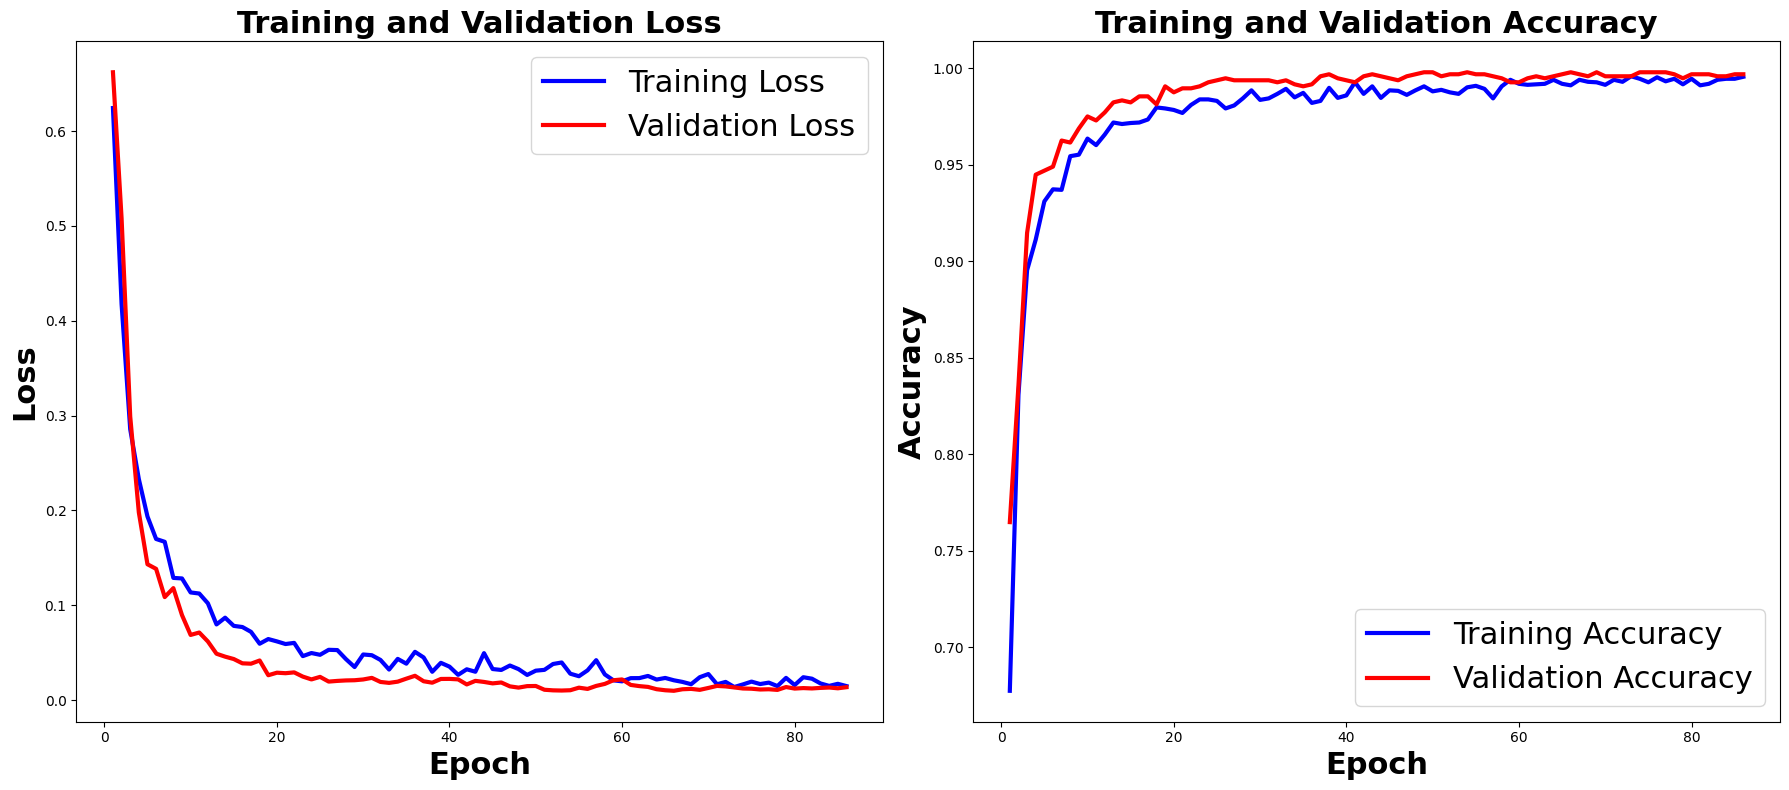

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 8))
train_loss = history.history['loss']
epochs = range(1, len(train_loss) + 1)
# Plot Training Loss
plt.subplot(1, 2, 1)

plt.plot(epochs,history.history['loss'], label='Training Loss', color='blue', linewidth=3)
plt.plot(epochs,history.history['val_loss'], label='Validation Loss', color='red', linewidth=3)
plt.xlabel('Epoch',fontsize=22, weight='bold')
plt.ylabel('Loss',fontsize=22, weight='bold')

plt.title('Training and Validation Loss',fontsize=22,weight='bold')
plt.legend(fontsize=22)

# Plot Training Accuracy
plt.subplot(1, 2, 2)

plt.plot(epochs,history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=3)
plt.plot(epochs,history.history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=3)
plt.xlabel('Epoch',fontsize=22, weight='bold')
plt.ylabel('Accuracy',fontsize=22, weight='bold')
plt.title('Training and Validation Accuracy',fontsize=22,weight='bold')
plt.legend(fontsize=22)

# Adjust layout to prevent overlap
plt.tight_layout()
# plt.savefig('TL_Training_and_Validation_Accuracy_and_Loss_2_sec.png')
# Show the plot
plt.show()

In [23]:
# === Step 6: Evaluate ===
loss, acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

38/38 [==============================] - 0s 7ms/step - loss: 0.0096 - accuracy: 0.9983
Test Accuracy: 0.9983


In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict probabilities for the test set
y_pred_proba = model.predict(x_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


38/38 [==============================] - 0s 7ms/step
Precision: 0.9983108108108109
Recall: 0.9983108108108109
F1 Score: 0.9983108108108109


### Confusion Matrix


38/38 [==============================] - 0s 7ms/step


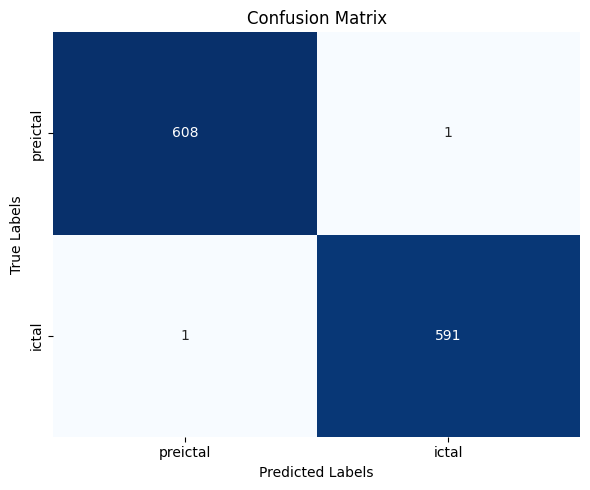

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# === Step 1: Predict labels ===
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# === Step 2: Compute confusion matrix ===
cm = confusion_matrix(y_test, y_pred)

# === Step 3: Plot using seaborn ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['preictal', 'ictal'],
            yticklabels=['preictal', 'ictal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


In [30]:
from sklearn.metrics import classification_report

# === Step 1: Predict probabilities and convert to binary labels ===
y_pred_proba = model.predict(x_test)
y_pred = (y_pred_proba > 0.5).astype(int)  # threshold at 0.5

# === Step 2: Generate classification report ===
report = classification_report(y_test, y_pred, target_names=['preictal', 'ictal'])
print("Classification Report:\n")
print(report)


38/38 [==============================] - 0s 7ms/step
Classification Report:

              precision    recall  f1-score   support

    preictal       1.00      1.00      1.00       609
       ictal       1.00      1.00      1.00       592

    accuracy                           1.00      1201
   macro avg       1.00      1.00      1.00      1201
weighted avg       1.00      1.00      1.00      1201



38/38 [==============================] - 0s 7ms/step


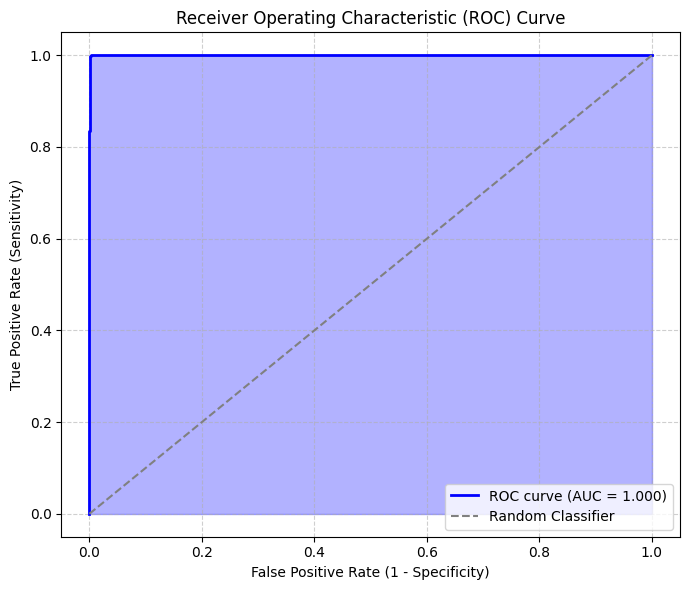

AUC Score: 0.9997254027426441


In [29]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# === Step 1: Predict probabilities for the positive class ===
y_pred_proba = model.predict(x_test)  # already available

# === Step 2: Compute ROC curve points ===
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# === Step 3: Compute AUC score ===
auc_score = roc_auc_score(y_test, y_pred_proba)

# === Step 4: Plot ROC curve with filled area ===
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.fill_between(fpr, tpr, alpha=0.3, color='blue')  # Fill area under the curve
plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--', label='Random Classifier')

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# === Step 5 (optional): Print AUC value ===
print("AUC Score:", auc_score)
